## Sistem Klasifikasi Jenis dan Kondisi Kesehatan Daun Berbasis Citra Digital

In [17]:
# Import Libraries
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split

In [18]:
# Konfigurasi
DATASET_DIR = "Dataset"
IMG_SIZE = 128

In [19]:
# Mapping Label
species_names = sorted([
    d for d in os.listdir(DATASET_DIR)
    if os.path.isdir(os.path.join(DATASET_DIR, d))
])

species_to_idx = {name:i for i,name in enumerate(species_names)}
idx_to_species = {i:name for name,i in species_to_idx.items()}

condition_to_idx = {"healthy":0, "diseased":1}
idx_to_condition = {0:"healthy", 1:"diseased"}

print("Species:", species_names)

Species: ['Alstonia Scholaris', 'Arjun', 'Chinar', 'Gauva', 'Jamun', 'Jatropha', 'Lemon', 'Mango', 'Pomegranate', 'Pongamia Pinnata']


In [20]:
# Preprocessing CNN
def preprocess_for_cnn(img_bgr):
    img = cv2.resize(img_bgr, (IMG_SIZE, IMG_SIZE))

    # RGB
    rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) / 255.0

    # HSV
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV) / 255.0

    # Edge
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    edge = cv2.Canny(gray, 100, 200)
    edge = edge / 255.0
    edge = np.expand_dims(edge, axis=-1)

    # Gabungkan
    combined = np.concatenate([rgb, hsv, edge], axis=-1)
    return combined

In [21]:
# Load Data
images = []
species_labels = []
condition_labels = []

for species in species_names:
    species_path = os.path.join(DATASET_DIR, species)

    for condition in ["healthy", "diseased"]:
        cond_path = os.path.join(species_path, condition)
        if not os.path.isdir(cond_path):
            continue

        for img_name in os.listdir(cond_path):
            img_path = os.path.join(cond_path, img_name)
            img = cv2.imread(img_path)
            if img is None:
                continue

            img = preprocess_for_cnn(img)

            images.append(img)
            species_labels.append(species_to_idx[species])
            condition_labels.append(condition_to_idx[condition])

images = np.array(images)
species_labels = np.array(species_labels)
condition_labels = np.array(condition_labels)

print("Total data:", images.shape)

Total data: (346, 128, 128, 7)


In [22]:
# Split Data
X_train, X_val, y_species_train, y_species_val, y_cond_train, y_cond_val = train_test_split(
    images,
    species_labels,
    condition_labels,
    test_size=0.2,
    random_state=42,
    stratify=species_labels
)

In [23]:
# MODEL CNN
inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 7))

x = layers.Conv2D(32, 3, activation='relu')(inputs)
x = layers.MaxPooling2D()(x)

x = layers.Conv2D(64, 3, activation='relu')(x)
x = layers.MaxPooling2D()(x)

x = layers.Conv2D(128, 3, activation='relu')(x)
x = layers.MaxPooling2D()(x)

x = layers.Flatten()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.3)(x)

species_output = layers.Dense(
    len(species_names),
    activation='softmax',
    name="species_output"
)(x)

condition_output = layers.Dense(
    2,
    activation='softmax',
    name="condition_output"
)(x)

model = models.Model(inputs=inputs, outputs=[species_output, condition_output])

model.compile(
    optimizer='adam',
    loss={
        "species_output": "sparse_categorical_crossentropy",
        "condition_output": "sparse_categorical_crossentropy"
    },
    metrics={
        "species_output": "accuracy",
        "condition_output": "accuracy"
    }
)

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 7)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 126, 126,  │      2,048 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 63, 63,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 61, 61,    │     18,496 │ max_pooling2d_3[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 30, 30,    │          0 │ conv2d_4[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 28, 28,    │     73,856 │ max_pooling2d_4[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 14, 14,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 25088)     │          0 │ max_pooling2d_5[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 256)       │  6,422,784 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 256)       │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ species_output      │ (None, 10)        │      2,570 │ dropout_1[0][0]   │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ condition_output    │ (None, 2)         │        514 │ dropout_1[0][0]   │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 6,520,268 (24.87 MB)

 Trainable params: 6,520,268 (24.87 MB)

 Non-trainable params: 0 (0.00 B)

In [24]:
# Train Model
history = model.fit(
    X_train,
    {
        "species_output": y_species_train,
        "condition_output": y_cond_train
    },
    validation_data=(
        X_val,
        {
            "species_output": y_species_val,
            "condition_output": y_cond_val
        }
    ),
    epochs=25,
    batch_size=16
)

Epoch 1/25
18/18 ━━━━━━━━━━━━━━━━━━━━ 8s 243ms/step - condition_output_accuracy: 0.5797 - condition_output_loss: 0.6602 - loss: 2.8186 - species_output_accuracy: 0.2754 - species_output_loss: 2.1532 - val_condition_output_accuracy: 0.6000 - val_condition_output_loss: 0.6745 - val_loss: 2.0673 - val_species_output_accuracy: 0.5286 - val_species_output_loss: 1.3659
Epoch 2/25
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 191ms/step - condition_output_accuracy: 0.7210 - condition_output_loss: 0.5511 - loss: 1.7312 - species_output_accuracy: 0.6087 - species_output_loss: 1.1445 - val_condition_output_accuracy: 0.5286 - val_condition_output_loss: 0.7778 - val_loss: 1.5526 - val_species_output_accuracy: 0.7429 - val_species_output_loss: 0.7494
Epoch 3/25
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 183ms/step - condition_output_accuracy: 0.8333 - condition_output_loss: 0.3961 - loss: 1.0631 - species_output_accuracy: 0.7826 - species_output_loss: 0.6575 - val_condition_output_accuracy: 0.7286 - val_condition_output_loss: 

In [25]:
def predict_leaf(img_path):
    img_original = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img_original, cv2.COLOR_BGR2RGB)

    # PREDIKSI
    img_input = preprocess_for_cnn(img_original)
    pred_species, pred_condition = model.predict(
        np.expand_dims(img_input, 0), verbose=0
    )

    species_label = idx_to_species[np.argmax(pred_species)]
    condition_label = idx_to_condition[np.argmax(pred_condition)]

    # SEGMENTASI
    blur = cv2.GaussianBlur(img_original, (5,5), 0)
    hsv = cv2.cvtColor(blur, cv2.COLOR_BGR2HSV)

    mask = cv2.inRange(
        hsv, np.array([25,40,40]), np.array([95,255,255])
    )

    segmented = cv2.bitwise_and(img_rgb, img_rgb, mask=mask)
    edges = cv2.Canny(mask, 100, 200)
    kernel = np.ones((5,5), np.uint8)
    edges = cv2.dilate(edges, kernel, iterations=1)

    # VISUALISASI 
    fig, axes = plt.subplots(
        2, 2,
        figsize=(13, 11),
        constrained_layout=True
    )

    fig.suptitle(
        f"Jenis Daun: {species_label} | Kondisi: {condition_label}",
        fontsize=19,
        fontweight="bold"
    )

    # Baris 1
    axes[0,0].imshow(img_rgb)
    axes[0,0].set_title("Gambar Asli", fontsize=16)
    axes[0,0].axis("off")

    axes[0,1].imshow(segmented)
    axes[0,1].set_title("HSV Segmentation", fontsize=16)
    axes[0,1].axis("off")

    # Baris 2
    axes[1,0].imshow(mask, cmap="gray")
    axes[1,0].set_title("Mask Daun", fontsize=16)
    axes[1,0].axis("off")

    axes[1,1].imshow(edges, cmap="gray")
    axes[1,1].set_title("Edge Detection", fontsize=16)
    axes[1,1].axis("off")

    # Border halus (opsional tapi cakep)
    for ax in axes.flatten():
        for spine in ax.spines.values():
            spine.set_visible(True)
            spine.set_linewidth(1)

    plt.show()

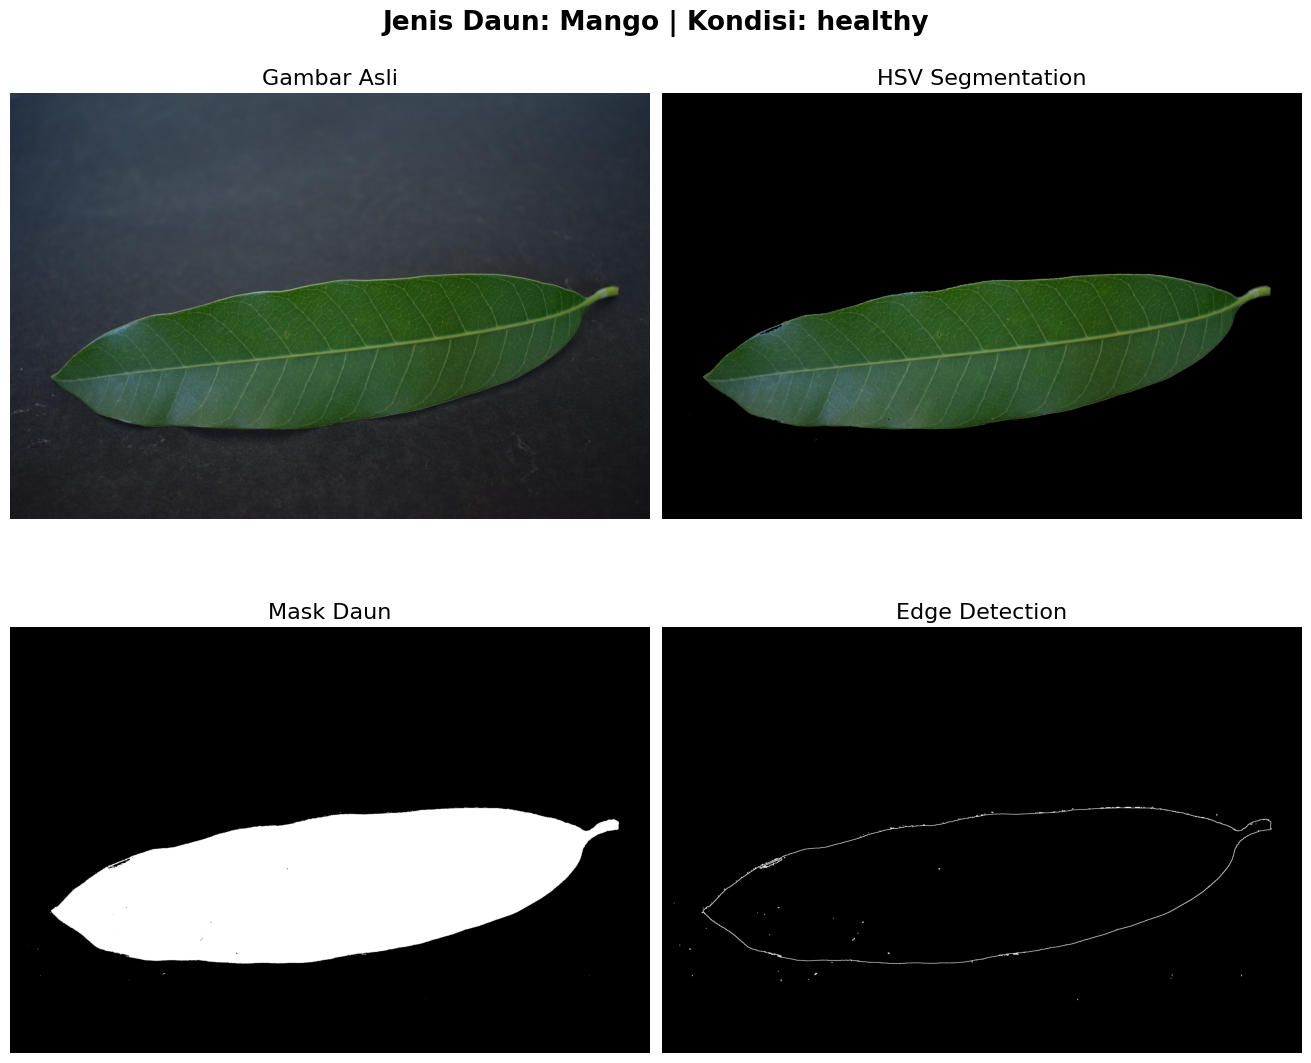

In [26]:
# Contoh Prediksi
test_img = "Test2.JPG"
predict_leaf(test_img)

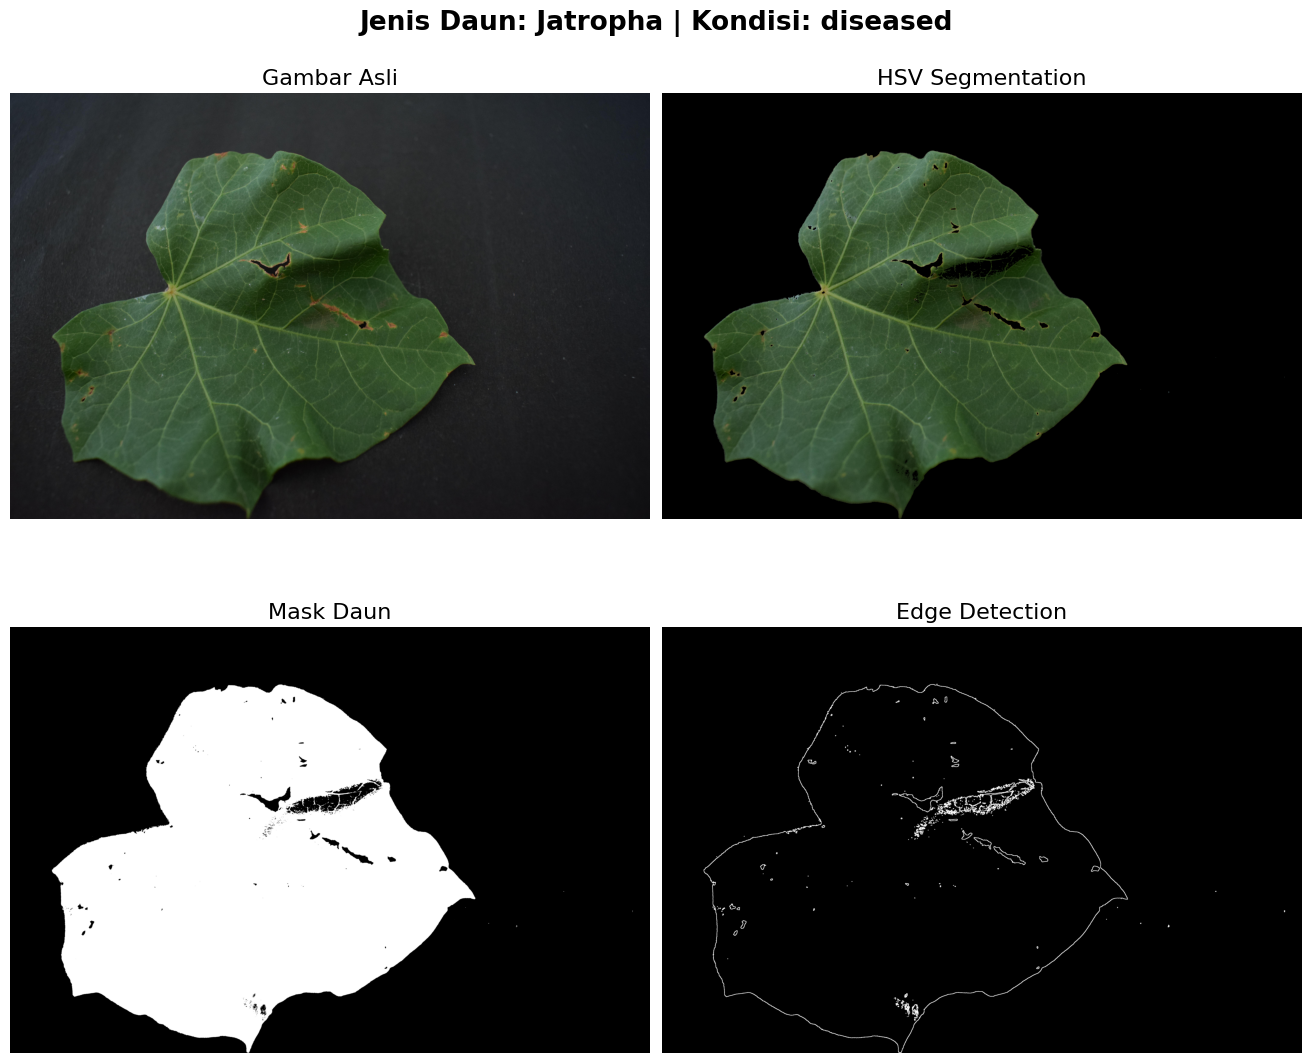

In [27]:
# Contoh Prediksi
test_img = "Test3.JPG"
predict_leaf(test_img)